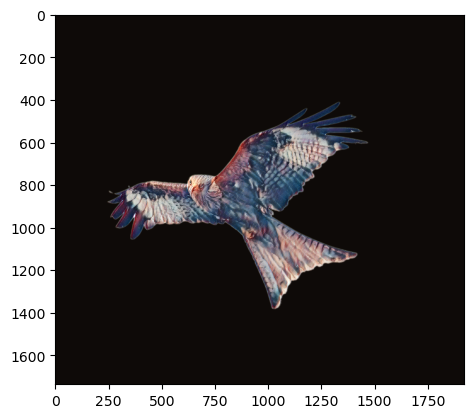

In [7]:
# Type 4: Linear Style Transfer (content, style, mask)(Partial convolution) Mask_bird

import torch
import utils
import numpy as np
import matplotlib.pyplot as plt
from libs.Matrix_masked import MulLayer
from libs.models_masked import encoder4, decoder4

content_fn = "data/content/FlyingBird.jpg"
content_im = utils.loadImage(content_fn)

masked_fn = "data/content/FlyingBird_mask.jpg"
masked_im = utils.loadMask(masked_fn)
masked_im = masked_im.to(dtype=torch.float32)   # Convert to torch tensor with dtype=torch.float32
# masked_im = torch.tensor(masked_im, dtype=torch.float32)
# masked_im = None

style_fn = "data/style/antimonocromatismo.jpg"
style_im = utils.loadImage(style_fn)

save_fn = "output_masked.png"

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc_ref = encoder4()
dec_ref = decoder4()
matrix_ref = MulLayer('r41')

enc_ref.load_state_dict(torch.load('models/vgg_r41.pth'))
dec_ref.load_state_dict(torch.load('models/dec_r41.pth'))
matrix_ref.load_state_dict(torch.load('models/r41.pth',map_location=torch.device('cpu')))


with torch.no_grad():
    # Reference comparison
    cF_ref,small_mask = enc_ref(content_im,masked_im)
    sF_ref,_ = enc_ref(style_im)
    feature_ref,transmatrix_ref = matrix_ref(cF_ref['r41'],sF_ref['r41'],small_mask)
    result = dec_ref(feature_ref,masked_im)
    

result = utils.toNumpy(result)
result = np.clip(result,0,1)

plt.imshow(result)
plt.show()

plt.imsave(save_fn,result)

To restore the original background, we need to change the input mask image ('masked_im') to a blank mask, where the entire image is considered as the content

(1736, 1920, 1, 1)


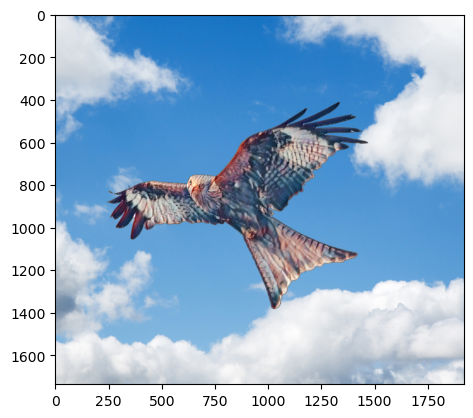

In [11]:
# back to original background

# Load the images
content_im = plt.imread("FlyingBird.jpg")
mask_im = plt.imread("FlyingBird_mask.jpg")

# Normalize the images to the range [0, 1]
content_im = content_im / 255.0
mask_im = mask_im / 255.0

# Create an alpha mask based on non-transparent regions of the mask image
alpha = np.mean(mask_im[:, :, :3], axis=2)  # Convert RGBA to grayscale
#alpha[alpha > 0] = 1.0  # Set non-transparent regions to fully opaque
alpha = np.expand_dims(alpha, axis=2)  # Add singleton dimension for compatibility

#plt.imshow(alpha,cmap="gray");plt.show()

print(alpha[...,None].shape)

# Alpha blending
blended_image = (result * alpha + content_im * (1 - alpha))
# blended_image = (mask_im * alpha + black_background * (1 - alpha))

# Clip the blended image to the range [0, 1]
blended_image = np.clip(blended_image, 0, 1)

# Display the blended image
plt.imshow(blended_image)

# plt.axis('off')
plt.show()
